In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import nnfs
from nnfs.datasets import sine_data


In [2]:


# Dense layer with regularizer
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights

        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        self.dinputs = np.dot(dvalues, self.weights.T)

# ReLU activation
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

# Linear activation
class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

# Loss base class
class Loss:
    def regularization_loss(self, layer):
        regularization_loss = 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        return regularization_loss

    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

# Mean Squared Error loss
class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        return np.mean((y_true - y_pred)**2, axis=-1)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples
        


In [3]:

# Optimizer Adam
class Optimizer_Adam:
    def __init__(self, learning_rate=0.003, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + \
            (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + \
            (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases ** 2

        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / \
            (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / \
            (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1


In [4]:

# Dataset generation function (I used a noisy increasing sine wave)
def sine_data():
   x=np.linspace(0,15,500)
   y = (9*np.sin(x)+3*x).reshape(1, 500)
   x=x.reshape(1,500)
   y+=0.3*np.random.randn(1,500)
   x+=0.3*np.random.randn(1,500)
   x=x.reshape(-1,1)
   y=y.reshape(-1,1)   
   return x, y


In [5]:

# Layers setup
X, y = sine_data()
dense1 = Layer_Dense(1, 128)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(128, 128)
activation2 = Activation_ReLU()
dense2h = Layer_Dense(128,100)
activation2h=Activation_ReLU()
dense3 = Layer_Dense(100, 1)
activation3 = Activation_Linear()
loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_Adam(learning_rate=0.005, decay=1e-3)

accuracy_precision = np.std(y) / 250


In [6]:


# Training loop
for epoch in range(20001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense2h.forward(activation2.output)
    activation2h.forward(dense2h.output)
    dense3.forward(activation2h.output)
    activation3.forward(dense3.output)

    data_loss = loss_function.calculate(activation3.output, y)
    regularization_loss = loss_function.regularization_loss(dense1) + \
                          loss_function.regularization_loss(dense2) + \
                          loss_function.regularization_loss(dense2h) + \
                          loss_function.regularization_loss(dense3)
    loss = data_loss + regularization_loss

    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)

    if not epoch % 100:
        print(f'epoch: {epoch}, acc: {accuracy:.3f}, loss: {loss:.3f} '
              f'(data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f}), '
              f'lr: {optimizer.current_learning_rate}')

    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2h.backward(dense3.dinputs)
    dense2h.backward(activation2h.dinputs)
    activation2.backward(dense2h.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense2h)
    optimizer.update_params(dense3)
    optimizer.post_update_params()





epoch: 0, acc: 0.000, loss: 780.606 (data_loss: 780.606, reg_loss: 0.000), lr: 0.005
epoch: 100, acc: 0.006, loss: 31.444 (data_loss: 31.444, reg_loss: 0.000), lr: 0.004549590536851684
epoch: 200, acc: 0.016, loss: 28.762 (data_loss: 28.762, reg_loss: 0.000), lr: 0.004170141784820684
epoch: 300, acc: 0.020, loss: 25.751 (data_loss: 25.751, reg_loss: 0.000), lr: 0.003849114703618168
epoch: 400, acc: 0.014, loss: 25.040 (data_loss: 25.040, reg_loss: 0.000), lr: 0.0035739814152966403
epoch: 500, acc: 0.016, loss: 24.941 (data_loss: 24.941, reg_loss: 0.000), lr: 0.00333555703802535
epoch: 600, acc: 0.018, loss: 24.921 (data_loss: 24.921, reg_loss: 0.000), lr: 0.0031269543464665416
epoch: 700, acc: 0.016, loss: 24.914 (data_loss: 24.914, reg_loss: 0.000), lr: 0.002942907592701589
epoch: 800, acc: 0.020, loss: 24.910 (data_loss: 24.910, reg_loss: 0.000), lr: 0.0027793218454697055
epoch: 900, acc: 0.018, loss: 24.908 (data_loss: 24.908, reg_loss: 0.000), lr: 0.0026329647182727752
epoch: 1000,

In [10]:


# Training loop for some extra runs 
for epoch in range(5001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense2h.forward(activation2.output)
    activation2h.forward(dense2h.output)
    dense3.forward(activation2h.output)
    activation3.forward(dense3.output)

    data_loss = loss_function.calculate(activation3.output, y)
    regularization_loss = loss_function.regularization_loss(dense1) + \
                          loss_function.regularization_loss(dense2) + \
                          loss_function.regularization_loss(dense2h) + \
                          loss_function.regularization_loss(dense3)
    loss = data_loss + regularization_loss

    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)

    if not epoch % 100:
        print(f'epoch: {epoch}, acc: {accuracy:.3f}, loss: {loss:.3f} '
              f'(data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f}), '
              f'lr: {optimizer.current_learning_rate}')

    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2h.backward(dense3.dinputs)
    dense2h.backward(activation2h.dinputs)
    activation2.backward(dense2h.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense2h)
    optimizer.update_params(dense3)
    optimizer.post_update_params()





epoch: 0, acc: 0.036, loss: 5.013 (data_loss: 5.013, reg_loss: 0.000), lr: 0.00013888117326815177
epoch: 100, acc: 0.036, loss: 5.014 (data_loss: 5.014, reg_loss: 0.000), lr: 0.00013849648218935238
epoch: 200, acc: 0.036, loss: 5.014 (data_loss: 5.014, reg_loss: 0.000), lr: 0.00013811391635821228
epoch: 300, acc: 0.030, loss: 5.015 (data_loss: 5.015, reg_loss: 0.000), lr: 0.0001377334582116688
epoch: 400, acc: 0.038, loss: 5.012 (data_loss: 5.012, reg_loss: 0.000), lr: 0.00013735509037964949
epoch: 500, acc: 0.030, loss: 5.015 (data_loss: 5.015, reg_loss: 0.000), lr: 0.00013697879568242834
epoch: 600, acc: 0.036, loss: 5.013 (data_loss: 5.013, reg_loss: 0.000), lr: 0.00013660455712802578
epoch: 700, acc: 0.032, loss: 5.012 (data_loss: 5.012, reg_loss: 0.000), lr: 0.0001362323579096507
epoch: 800, acc: 0.040, loss: 5.012 (data_loss: 5.012, reg_loss: 0.000), lr: 0.0001358621814031846
epoch: 900, acc: 0.040, loss: 5.014 (data_loss: 5.014, reg_loss: 0.000), lr: 0.00013549401116470653
epoch

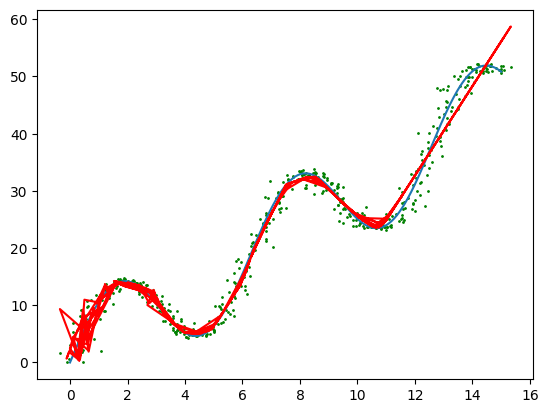

In [ ]:
# For final inference
X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense2h.forward(activation2.output)
activation2h.forward(dense2h.output)
dense3.forward(activation2h.output)
activation3.forward(dense3.output)


# Plot
plt.scatter(X_test, y_test, s=1,color="green")
xhi=np.linspace(0,15,500)
plt.plot(xhi,(9*np.sin(xhi)+3*xhi))
plt.plot(X_test, activation3.output,color="red")
plt.show()